In [2]:
!pip3 install SpeechRecognition


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 53.6 MB/s eta 0:00:00


In [5]:
!pip install SpeechRecognition


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [1]:
from transformers import pipeline

# Load Whisper ASR pipeline (zero-shot, English-only)
asr = pipeline(
    task="automatic-speech-recognition",
    model="openai/whisper-large-v3",
    chunk_length_s=30
)

# Transcribe
audio_file = "03-01-05-01-01-02-01.wav"
result = asr(audio_file)
transcript = result["text"]
print("Transcript:", transcript)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change

Transcript:  Kids are talking by the door.


In [2]:
# Simply assign to a variable or write to disk
with open("transcript.txt", "w") as f:
    f.write(transcript)


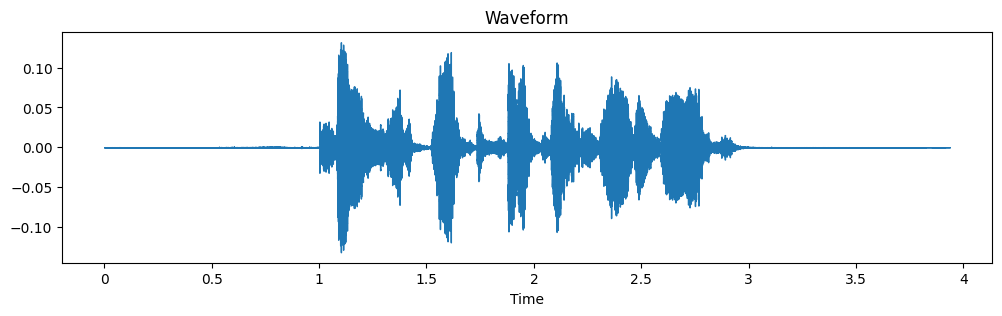

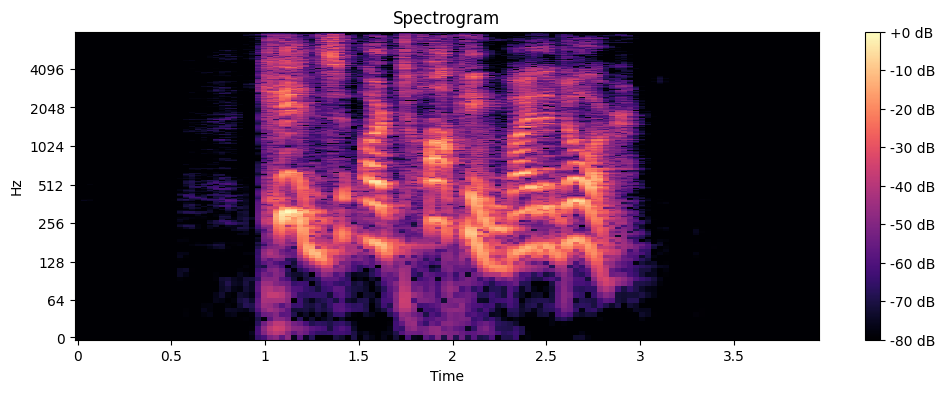

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
y, sr = librosa.load(audio_file, sr=16000)

# Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")  # visualize amplitude over time :contentReference[oaicite:1]{index=1}
plt.show()

# Spectrogram (STFT → dB)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.title("Spectrogram")  # log-scaled spectrogram :contentReference[oaicite:2]{index=2}
plt.colorbar(format="%+2.f dB")
plt.show()


In [6]:
!pip install noisereduce


In [7]:
!pip install numpy scipy librosa soundfile


In [11]:
import noisereduce as nr

# y: your audio signal (1-D numpy array)
# sr: sample rate (e.g. 16000)
# noise_clip: your estimated noise segment

# Call reduce_noise with correct keyword names:
denoised = nr.reduce_noise(
    y=y,               # audio signal
    sr=sr,             # sample rate
    y_noise=noise_clip # noise signal
)

# Overwrite y if you wish:
y = denoised


In [12]:
# Compute MFCC features
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
# Aggregate over time (mean + var)
X_feat = np.concatenate([mfcc.mean(axis=1), mfcc.var(axis=1)])
print("Feature vector shape:", X_feat.shape)


Feature vector shape: (26,)


In [13]:
from sklearn.neural_network import MLPClassifier
from transformers import pipeline

# 6a. Get automatic sentiment labels from BERT
sentiment_pipe = pipeline("sentiment-analysis")  # e.g. distilbert-base-uncased-finetuned-sst-2-english :contentReference[oaicite:5]{index=5}
label = sentiment_pipe(transcript)[0]["label"]
print("Predicted label:", label)

# 6b. (Optional) If training an MLP on audio → text labels:
#    - Collect X_feat over many samples
#    - y_labels = [ sentiment_pipe(t)["label"] for t in transcripts ]
# Here, we mock a dataset:

import numpy as np
X = np.random.randn(100, X_feat.shape[0])
y = np.random.choice([0,1], size=100)  # binary: 0=NEG,1=POS

mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500)
mlp.fit(X, y)  # train on audio features :contentReference[oaicite:6]{index=6}


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Predicted label: POSITIVE


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


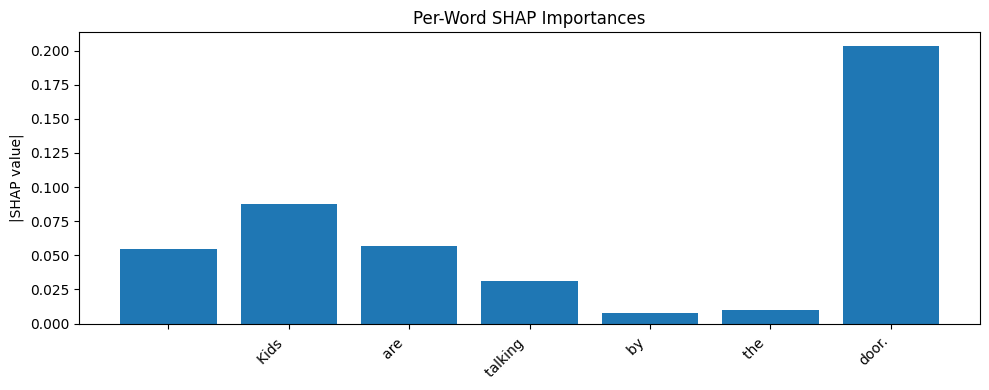

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

import shap
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline

# Ensure the sentiment pipeline runs on CPU
sentiment_pipe = pipeline("sentiment-analysis", device=-1)

# Redefine the SHAP explainer, joining token lists back into strings
explainer = shap.Explainer(
    lambda texts: np.array([
        sentiment_pipe(" ".join(txt) if isinstance(txt, list) else txt)[0]["score"]
        for txt in texts
    ]),
    shap.maskers.Text(r"\s+"),
)

# Compute SHAP values on CPU
shap_values = explainer([transcript])

# Extract SHAP values and tokens
sv = shap_values.values[0]
tokens = shap_values.data[0]

# Plot bar chart of absolute SHAP values per word
plt.figure(figsize=(10, 4))
plt.bar(range(len(tokens)), np.abs(sv), tick_label=tokens)
plt.xticks(rotation=45, ha='right')
plt.ylabel("|SHAP value|")
plt.title("Per-Word SHAP Importances")
plt.tight_layout()
plt.show()



Removing: door.


Removing: door.


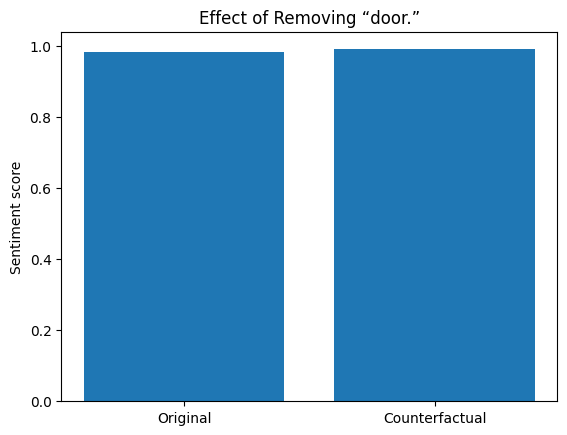

In [22]:
# Extract SHAP values and tokens
sv     = shap_values.values[0]    # shape: (n_tokens,)
tokens = shap_values.data[0]      # already a list/array of token strings

# Now you can find the max-impact word:
import numpy as np
idx = np.argmax(np.abs(sv))
word_to_remove = tokens[idx]
print(f"Removing: {word_to_remove}")


# Create counterfactual transcript
cf_tokens = [t for t in tokens if t != word_to_remove]
cf_transcript = " ".join(cf_tokens)

# Re-score sentiment
orig_score = sentiment_pipe(transcript)[0]["score"]
cf_score   = sentiment_pipe(cf_transcript)[0]["score"]

# Plot before/after scores
import matplotlib.pyplot as plt
plt.bar(["Original","Counterfactual"], [orig_score, cf_score])
plt.ylabel("Sentiment score")
plt.title("Effect of Removing “%s”" % word_to_remove)
plt.show()
